### Week 5
### More on working with climate models
#### Doing an area-weighted spatial average of global data

The first 5 cells are repeat from last week

In [49]:
import numpy as np
import matplotlib.pyplot as py
import math
import xarray

In [29]:
filename = 'cmip6_tas.nc'
nc_file = xarray.open_dataset(filename)
tasdata = nc_file['tas'].data - 273.15 #convert to celsius
time = nc_file['tas'].data
lat = nc_file['lat'].data
lon = nc_file['lon'].data
nc_file.close() #we've extracted the data we need and we can close the file

In [32]:
nmonths = 12
nyears = int(len(time)/nmonths)
date = np.zeros(time.size)
for i in range(time.size):
    date[i] = 1850.0 + i/12 + 0.5

Now we plot the unweighted temperature data

In [65]:
tasyearmean = np.zeros((nyears, len(lat), len(lon)))
globaltas = np.zeros(nyears)

for t in range(nyears):
    tasyearmean[t,:,:] = np.mean(tasdata[t*12 : t*12+12, :, :], axis=0)
    #globaltas[t] = np.average(tasyearmean[t, :, :], weights = areacella) #weighted average based on gridcell area
    globaltas[t] = np.average(tasyearmean[t, :, :]) #unweighted
    
globaltas = globaltas - 273.15 #to celcius

tasfinal = tasyearmean[-1,:,:]
tasinitial = tasyearmean[0,:,:]
tasdiff = tasfinal - tasinitial

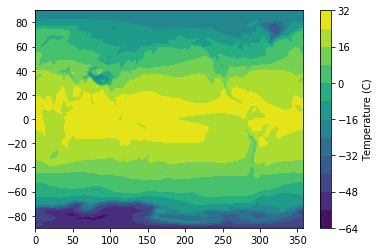

In [66]:
fig = py.figure()
ax1 = fig.add_subplot(111)
contour_plot = ax1.contourf(lon, lat, tasinitial, 10)
cbar = py.colorbar(contour_plot)
cbar.set_label('Temperature (C)')


plot the change

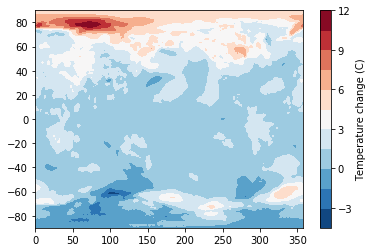

In [67]:
fig = py.figure()
ax1 = fig.add_subplot(111)
contour_plot = ax1.contourf(lon, lat, tasfinal-tasinitial, 10, cmap='RdBu_r') 
cbar = py.colorbar(contour_plot) #still need to center at 0
cbar.set_label('Temperature change (C)')

In [62]:
#get area info
filename = 'area_historical.nc'
nc_file = xarray.open_dataset(filename)
areacella = nc_file['areacella'].data
nc_file.close()

print(np.sum(areacella)) #total surface area of the earth, 5.1 x 10^14 m2

510103740000000.0


In [63]:
arealat = np.zeros(len(lat))
Re = 6.371e6 #radius of earth
delat = lat[1] - lat[0]
print('lat diff =', delat)

for i in range(len(lat)):
    htop = Re*(1 - math.sin(math.radians(lat[i] + delat)))
    hbot = Re*(1 - math.sin(math.radians(lat[i] - delat)))
    areatop = 2 * math.pi * Re * htop
    areabot = 2 * math.pi * Re * hbot
    areadiff = areabot - areatop
    arealat[i] = areadiff/len(lon)

lat diff = 1.2676086


In [64]:
arealat

array([0.00000000e+00, 1.73347204e+09, 3.46608521e+09, 5.19701234e+09,
       6.92538541e+09, 8.65037926e+09, 1.03711392e+10, 1.20868127e+10,
       1.37965806e+10, 1.54995856e+10, 1.71950146e+10, 1.88820276e+10,
       2.05597886e+10, 2.22274969e+10, 2.38843159e+10, 2.55294549e+10,
       2.71620984e+10, 2.87814378e+10, 3.03866999e+10, 3.19770893e+10,
       3.35518182e+10, 3.51100794e+10, 3.66512618e+10, 3.81744502e+10,
       3.96789543e+10, 4.11640376e+10, 4.26289734e+10, 4.40730489e+10,
       4.54955487e+10, 4.68957808e+10, 4.82730600e+10, 4.96267162e+10,
       5.09560786e+10, 5.22605009e+10, 5.35393444e+10, 5.47919833e+10,
       5.60178081e+10, 5.72162115e+10, 5.83866107e+10, 5.95284328e+10,
       6.06411189e+10, 6.17241277e+10, 6.27769225e+10, 6.37989914e+10,
       6.47898342e+10, 6.57489687e+10, 6.66758688e+10, 6.75702364e+10,
       6.84314811e+10, 6.92592336e+10, 7.00530861e+10, 7.08126525e+10,
       7.15375588e+10, 7.22274513e+10, 7.28819934e+10, 7.35008626e+10,
      